# Calculating the Monthly Recurring Revenue

# Introduction

## The business question

Calculate the Monthly Recurring Revenue (**MRR**) of a plugin using sales and licenses data.


## What is the MRR?

MRR is the income likely to continue to be generated regularly, tracked on a monthly basis. MRR excludes all one-time, non-recurring payments.  

In the case of an Attlasian plugin, it includes the amount the vendor receives for each sale.

## How does this help Railsware?

Analyzing the MRR helps:
* Make precise revenue forecast
* Identify possible sources of variations in revenue
* Make better budgets
* Make informed decisions about asset allocation (advertising, sales, hiring, etc.)


## Methodology and Overview of the Solution

* **Refunds**: are removed from the sales tables, along with the corresponding transaction that originated the transaction.

For instance, if a refund of $17.5 was issued to cancel a transaction of the same amount, licenceId and maintenance date, both transactions are removed from the dataset.

*Sample Refund Transaction:*

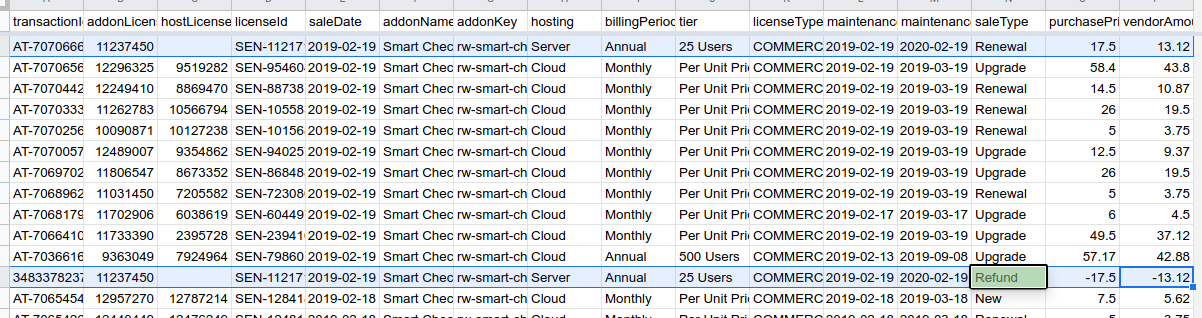

Then, refunded transactions are not considered and this allows us to calculate the actual MRR and net sales (gross sales minus refunds) in an easy way.

* **Purchase Price vs. Vendor Amount**: since per the definition of MRR, it includes income; I use the vendor amount and not the purchase price. From the point of view of the publisher, the income is the vendor amount and not the sale price.

* **Assumptions: Upgrades and Downgrades**: The dataset includes a ‘saleType’ column with the values ‘New’, ‘Renewal’, ‘Refund’, and ‘Upgrade’. This analysis doesn't discriminate between proper upgrades, like increases in the number of users, and other modifications of plans, like decreases in the number of users, plan, license type, or hosting variation. From now on, I refer to 'Upgrades' as the category that comprises all these modifications.

* **Overview of the Solution**:
    * Remove refunds and refunded transactions.
    * Perform an exploratory analysis of the data.
    * Initialize an empty Pandas DataFrame to hold the MRR and sales figures.
    * Iterate over rows of the filtered sales data.
        * If the billing period of the row is monthly, the vendor amount is added directly to the mrr dataframe.
        * If the billing period is annual, the vendor amount divided 12 is added to the mrr dataframe cell corresponding to the month and also to the next 11 months.
    * The total MRR for each month is the sum of the MRR of each category.
    * To calculate the net sales per month, group the sales data (excluding refunding transactions and refunds) by month, and count the number of rows per month.

* **Tests**: the notebook includes non exhaustive tests to check the accuracy of the MRR table.


# Importing libraries and data

## Libraries and settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import gspread
from google.colab import drive, auth
from oauth2client.client import GoogleCredentials
drive.mount('/content/gdrive')
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

Mounted at /content/gdrive


## Importing data

Provided data was a Google Sheet with sales transactions data of the Smart Checklist for JIRA data extracted using The Atlassian Marketplace REST API.


In [2]:
# worksheetSales = gc.open('MRR-colab-copy').get_worksheet(1)
# Data Analyst - MRR Test Task. Federico Anzil [01-2021]
worksheetSales = (
    gc.open(
        'Data Analyst - MRR Test Task. Federico Anzil [01-2021]'
        ).get_worksheet(1)
)
rows = worksheetSales.get_all_values()
sales = pd.DataFrame.from_records(rows[1:], columns=rows[0])
sales.head(5)

,transactionId,addonLicenseId,hostLicenseId,licenseId,saleDate,addonName,addonKey,hosting,billingPeriod,tier,licenseType,maintenanceStartDate,maintenanceEndDate,saleType,purchasePrice,vendorAmount
0,AT-71004759,12322025,12260340,SEN-12339366,2019-02-24,Smart Checklist for Jira. Enterprise,rw-smart-checklist-biz,Cloud,Monthly,Per Unit Pricing (12 users),COMMERCIAL,2019-02-24,2019-03-24,Renewal,6,4.5
1,AT-71004540,12808966,12182250,SEN-12261475,2019-02-24,Smart Checklist for Jira. Enterprise,rw-smart-checklist-biz,Cloud,Monthly,Per Unit Pricing (10 users),COMMERCIAL,2019-02-24,2019-03-24,Renewal,5,3.75
2,AT-71002970,12011999,11661004,SEN-11736283,2019-02-24,Smart Checklist for Jira. Enterprise,rw-smart-checklist-biz,Cloud,Monthly,Per Unit Pricing (45 users),COMMERCIAL,2019-02-24,2019-03-24,Renewal,22.5,16.87
3,AT-71000730,11546508,10933194,SEN-10925509,2019-02-24,Smart Checklist for Jira. Enterprise,rw-smart-checklist-biz,Cloud,Monthly,Per Unit Pricing (14 users),COMMERCIAL,2019-02-24,2019-03-24,Upgrade,7,5.25
4,AT-71000029,12361793,10346791,SEN-10374853,2019-02-24,Smart Checklist for Jira. Enterprise,rw-smart-checklist-biz,Cloud,Monthly,Per Unit Pricing (69 users),COMMERCIAL,2019-02-24,2019-03-24,Upgrade,34.5,25.87


In [3]:
rows = worksheetSales.get_all_values()
sales = pd.DataFrame.from_records(rows[1:], columns=rows[0])
sales.head(5)

,transactionId,addonLicenseId,hostLicenseId,licenseId,saleDate,addonName,addonKey,hosting,billingPeriod,tier,licenseType,maintenanceStartDate,maintenanceEndDate,saleType,purchasePrice,vendorAmount
0,AT-71004759,12322025,12260340,SEN-12339366,2019-02-24,Smart Checklist for Jira. Enterprise,rw-smart-checklist-biz,Cloud,Monthly,Per Unit Pricing (12 users),COMMERCIAL,2019-02-24,2019-03-24,Renewal,6,4.5
1,AT-71004540,12808966,12182250,SEN-12261475,2019-02-24,Smart Checklist for Jira. Enterprise,rw-smart-checklist-biz,Cloud,Monthly,Per Unit Pricing (10 users),COMMERCIAL,2019-02-24,2019-03-24,Renewal,5,3.75
2,AT-71002970,12011999,11661004,SEN-11736283,2019-02-24,Smart Checklist for Jira. Enterprise,rw-smart-checklist-biz,Cloud,Monthly,Per Unit Pricing (45 users),COMMERCIAL,2019-02-24,2019-03-24,Renewal,22.5,16.87
3,AT-71000730,11546508,10933194,SEN-10925509,2019-02-24,Smart Checklist for Jira. Enterprise,rw-smart-checklist-biz,Cloud,Monthly,Per Unit Pricing (14 users),COMMERCIAL,2019-02-24,2019-03-24,Upgrade,7,5.25
4,AT-71000029,12361793,10346791,SEN-10374853,2019-02-24,Smart Checklist for Jira. Enterprise,rw-smart-checklist-biz,Cloud,Monthly,Per Unit Pricing (69 users),COMMERCIAL,2019-02-24,2019-03-24,Upgrade,34.5,25.87


# Data Cleaning and Preparation


In [4]:
sales['vendorAmount'] = pd.to_numeric(sales['vendorAmount'])

In [5]:
# initialize empty dataframe to hold MRR data
dates = pd.period_range(
    min(pd.to_datetime(sales['saleDate'], format="%Y-%m-%d")),
    max(pd.to_datetime(sales['saleDate'], format="%Y-%m-%d")),
    freq='M'
)
dates = [str(d)[:7] for d in dates]
mrr = pd.DataFrame(
    index=dates,
    columns=['NewMonthly', 'NewAnnual',
             'RenewalMonthly', 'RenewalAnnual',
             'UpgradeMonthly', 'UpgradeAnnual']
    ).fillna(0.0)

In [6]:
# remove refunds and original transactions
a = len(sales)
sales['refundId'] = (sales['licenseId'].astype(str) +
                     sales['vendorAmount'].apply(abs).astype(str) +
                     sales['maintenanceStartDate'])
rows_to_remove = [i for i in sales[sales["saleType"] == "Refund"]['refundId']]
sales = sales.query("refundId not in @rows_to_remove")
b = len(sales)
print(f'{a - b} rows removed from sales')
sales.drop(columns='refundId', inplace=True)  # drop unneded column

50 rows removed from sales


# Data Overview

In [7]:
sales_eda = sales.copy()
sales_eda['month'] = sales['saleDate'].str[:7]
sales_by_month = (
    sales_eda
    .groupby('month')['vendorAmount']
    .agg(['sum', 'count', 'mean', 'median'])
)
sales_by_month

,sum,count,mean,median
month,,,,
2017-02,22.50,1,22.500000,22.500
2017-03,204.75,8,25.593750,13.125
2017-04,282.75,17,16.632353,7.500
2017-05,256.87,18,14.270556,11.250
2017-06,262.50,19,13.815789,15.000
2017-07,1397.25,32,43.664062,15.000
2017-08,261.53,32,8.172813,6.410
2017-09,1657.12,43,38.537674,8.320
2017-10,542.03,47,11.532553,7.650


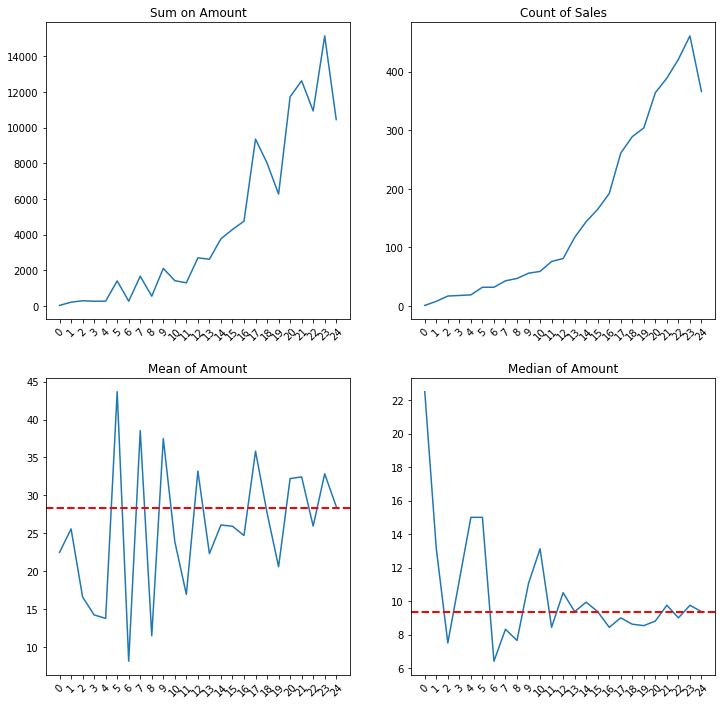

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))

axs[0, 0].set_title('Sum on Amount')
axs[0, 0].plot(sales_by_month['sum'])
axs[0, 0].set_xticklabels(axs[0, 0].get_xticks(), rotation = 45)

axs[0, 1].set_title('Count of Sales')
axs[0, 1].plot(sales_by_month['count'])
axs[0, 1].set_xticklabels(axs[0, 1].get_xticks(), rotation = 45)

axs[1, 0].set_title('Mean of Amount')
axs[1, 0].plot(sales_by_month['mean'])
axs[1, 0].axhline(sales['vendorAmount'].mean(),
                  color='red',
                  linestyle='--',
                  linewidth=2,
                  label='Mean')
axs[1, 0].set_xticklabels(axs[1, 0].get_xticks(), rotation = 45)

axs[1, 1].set_title('Median of Amount')
axs[1, 1].plot(sales_by_month['median'])
axs[1, 1].axhline(sales['vendorAmount'].median(),
                  color='red', linestyle='--',
                  linewidth=2,
                  label='Median')
axs[1, 1].set_xticklabels(axs[1, 1].get_xticks(), rotation = 45)
fig.show()

**Observations**:
* Timeframe of the data is 2 years.
* There was only 1 sale in the first month.
* Peak number of sales was 461 in 2019-01
* Peak sum of monthly amount was 15,142 in 2019-01
* Count of Sales and Amount has been increasing until 2019-02
* In 2019-02 the sum of monthly amount dropped sharply from 15,142 to 10,446
* In 2019-02 the count of sales dropped from 461 to 366
* There is no clear trend in the median and mean vendorAmount.

In [9]:
fig = px.histogram(sales, x="vendorAmount", title='Histogram of vendorAmount')
fig.show()

Observations:
* The fact that all prices are positive, means that refunds are not included.
* There is a small number of large sales. *Note: Plot can be zoomed to exclude large values*.

In [10]:
pd.pivot_table(
    sales,
    values='vendorAmount',
    index='billingPeriod',
    columns='hosting',
    aggfunc=[pd.Series.count, np.sum, np.mean],
    margins=True
    )

count                     ...        mean                        
hosting         Cloud Data Center Server  ... Data Center      Server         All
billingPeriod                             ...                                    
Annual           65.0         1.0  390.0  ...      1050.0  110.535692  125.772588
Monthly        3506.0         NaN    NaN  ...         NaN         NaN   15.666386
All            3571.0         1.0  390.0  ...      1050.0  110.535692   28.338882

[3 rows x 12 columns]

**Observations**:
* Sum of revenue from Annual and Monthly sales is similar. 
* There was only 1 Data Center license sold.
* Sum of amount from Cloud licenses was 68,119 while the sum of vendor amount from Server licenses was 43,108

# Create MRR Table

In [11]:
for i in range(len(sales)):
    col = sales.iloc[i]["saleType"]  # New, Renewal or Upgrade
    billingPeriod = sales.iloc[i]["billingPeriod"]  # Monthly or Annual
    date: str = sales.iloc[i]["saleDate"][:7]  # Month
    if sales.iloc[i]["billingPeriod"] == "Monthly":
        mrr.loc[date][col+billingPeriod]: float = (
            mrr.loc[date][col+billingPeriod] + sales.iloc[i, -1]
            )
    else:  # Annual
        list_of_dates = pd.date_range(
            pd.to_datetime(date), periods=12, freq="MS"
        )
        for date in list_of_dates:
            date_month: str = date.strftime("%Y-%m")
            # if we add 12 month, date might be above max date
            if date_month in mrr.index:
                mrr.loc[date_month][col+billingPeriod] = (
                    mrr.loc[date_month][col+billingPeriod] +
                    sales.iloc[i, -1] / 12
                )
# mrr = pd.DataFrame(mrr.sum(axis=1).rename('mrr'))
mrr['total'] = pd.DataFrame(mrr.sum(axis=1).rename('mrr'))
mrr

,NewMonthly,NewAnnual,RenewalMonthly,RenewalAnnual,UpgradeMonthly,UpgradeAnnual,total
2017-02,22.50,0.000000,0.00,0.000000,0.00,0.000000,22.500000
2017-03,60.00,10.187500,22.50,0.000000,0.00,0.000000,92.687500
2017-04,75.00,22.187500,63.75,0.000000,0.00,0.000000,160.937500
2017-05,105.00,24.530833,123.75,0.000000,0.00,0.000000,253.280833
2017-06,41.25,24.530833,206.25,0.000000,15.00,0.000000,287.030833
2017-07,120.00,97.530833,221.25,15.000000,0.00,0.000000,453.780833
2017-08,51.51,99.155833,151.31,15.000000,39.21,0.000000,356.185833
2017-09,31.48,156.780833,96.50,65.000000,181.39,4.687500,535.838333
2017-10,143.16,166.030833,100.77,65.000000,187.10,4.687500,666.748333
2017-11,104.08,247.655833,264.79,65.000000,366.87,36.698333,1085.094167


In [12]:
# calculate sales per month
# refunds and original transactions are already deducted from sales
sales_per_month = (
    sales['saleDate'].str[:7]
    .value_counts()
    .rename("Sales")
)
mrr = (
    mrr.merge(sales_per_month, left_index=True, right_index=True, how="outer")
)
mrr

,NewMonthly,NewAnnual,RenewalMonthly,RenewalAnnual,UpgradeMonthly,UpgradeAnnual,total,Sales
2017-02,22.50,0.000000,0.00,0.000000,0.00,0.000000,22.500000,1
2017-03,60.00,10.187500,22.50,0.000000,0.00,0.000000,92.687500,8
2017-04,75.00,22.187500,63.75,0.000000,0.00,0.000000,160.937500,17
2017-05,105.00,24.530833,123.75,0.000000,0.00,0.000000,253.280833,18
2017-06,41.25,24.530833,206.25,0.000000,15.00,0.000000,287.030833,19
2017-07,120.00,97.530833,221.25,15.000000,0.00,0.000000,453.780833,32
2017-08,51.51,99.155833,151.31,15.000000,39.21,0.000000,356.185833,32
2017-09,31.48,156.780833,96.50,65.000000,181.39,4.687500,535.838333,43
2017-10,143.16,166.030833,100.77,65.000000,187.10,4.687500,666.748333,47
2017-11,104.08,247.655833,264.79,65.000000,366.87,36.698333,1085.094167,56


In [13]:
# Export the data to pkl to perform tests to validate the accuracy of the data
# See section Tests 
mrr.to_pickle('./gdrive/MyDrive/Colab Notebooks/mrr_control.pkl')

## MRR Table per the task instructions

In [14]:
# Table to be exported as per the task instructions
mrr[['total', 'Sales']].rename(columns={'index': 'month', 'total' : 'MRR'})

,MRR,Sales
2017-02,22.500000,1
2017-03,92.687500,8
2017-04,160.937500,17
2017-05,253.280833,18
2017-06,287.030833,19
2017-07,453.780833,32
2017-08,356.185833,32
2017-09,535.838333,43
2017-10,666.748333,47
2017-11,1085.094167,56


In [15]:
# export to a Google Sheet, only totals according to instructions 
# "table of 3 columns"
df_to_export = (
    mrr[['total', 'Sales']]
    .rename(columns={'total' : 'MRR'})
    .rename_axis('Month')
    .reset_index()
)
from gspread_dataframe import set_with_dataframe
gc.create('mrr_totals')
worksheet = gc.open('mrr_totals').sheet1
set_with_dataframe(worksheet, df_to_export)

View exported data in this [Google Sheet](https://docs.google.com/spreadsheets/d/1cxMKq8odsO3SVtJWLCVNP21cUR9_PFHDA5Dhyr9umJg/edit#gid=0).

# Data Visualization

In [16]:
# visualization
import plotly.express as px

In [17]:
fig = px.bar(
    mrr,
    x=mrr.index,
    y="Sales",
    text='Sales',
    labels={"x": "Month"},
    title="Sales Per Month"
    )
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

Observations:
* Sales have been steadily increasing until Jan-2019. In Feb-2020 there was a decrease in the number of sales.

In [18]:
columns=['NewMonthly', 'NewAnnual', 
         'RenewalMonthly', 'RenewalAnnual',
         'UpgradeMonthly', 'UpgradeAnnual']
mrr.reset_index()
mrr_2 = (
    mrr.reset_index()[
                      ['index'] + columns
    ].melt(
          value_vars=columns, id_vars=['index']
          )
)
fig = px.bar(
    mrr_2,
    x="index",
    y="value",
    title="Evolution of MRR per category",
    color="variable",
    color_discrete_sequence=['cornflowerblue', 'deepskyblue', 
                             'mediumaquamarine', 'darkseagreen', 
                             'gold', 'goldenrod'], 
    text='value',
    labels={
        "value": "MRR",
        "index": "Month",
        },
)
fig.update_layout(barmode='stack')
fig.update_traces(texttemplate='%{text:.2s}', textposition='inside')
fig.show()

The following charts display the evolution of the **variation** of sales and MRR, comparing each month value with the value in the previous month.

In [19]:
fig = px.bar(
    mrr.diff(),
    x=mrr.index,
    y="Sales",
    text='Sales',
    labels={"x": "Month"},
    title="Sales vs Previous Month Sales"
    )
fig.update_traces(textposition='outside')
fig.show()

In [20]:
fig = px.bar(
    mrr.diff(),
    x=mrr.index,
    y="total",
    text='total',
    labels={"x": "Month"},
    title="MRR vs Previous Month MRR"
    )
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

**Observations**: 
* MRR has been increasing until Jan-2019.
* Peak MRR was $10,707 on Jan-2019
* **On Feb-2019**
    * there was a decrease in MRR. It was $9,891
    * *New MRR* kept increasing.
    * *Upgrade MRR* and *Renewal MRR* decreased.
* All 3 *New MRR*, *Upgrade MRR*, and *Renewal MRR* have been increasing since the first sale, except for Feb-2019, when *New MRR* kept raising but the other 2 categories didn't.
* In the categories 'Upgrade' and 'Renewal', monthly MRR is larger than annual MRR. In the category 'New', annual MRR is larger than monthly MRR.

# Tests

Non-exhaustive tests to validate the MRR table data were performed. 

Tests are done using Pytest.

You can see the tests in this [notebook](https://colab.research.google.com/drive/1hCzGYp54h6u24wIJHIosebv1PEyUhHjg).

# Conclusions

* The EDA summarizes the evolution of sales and income generated from different segments.

* The MRR table and visualizations provide an overview of the evolution of the MRR across different segments. 

* The MRR analysis can help make informed decisions about budget allocations and identify trends in the evolution of recurring revenue.

## Limitations and Improvement Opportunities

* Besides *New*, *Upgrade* and *Renewal MRR*, *Churn MRR* could be included to show the evolution of churned revenue. 

* The analysis could take more features into consideration, like the number of users, hosting type, etc. Upgrades could be categorized into hosting type changes, tier changes, etc.

* Tests should be extended. In particular, annual figures were not tested.

## See also

See also the cohort analysis of the sales data in this [notebook](https://colab.research.google.com/drive/1B5cHwu7QwxzgdtU-4pJmFVjwxMOY02-y#scrollTo=Bh8oyYDot0S7)